<a href="https://colab.research.google.com/github/nsubbaian/BayesianML/blob/master/Project2/BayesMLProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2
You must reproduce figures 3.7 and 3.8 in the textbook. The exact data they used is described in the text. Note your figure will look slightly different because they rely on random draws from the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

### Figure 3.7

In [2]:
#---------------------------------------- GENERATION OF SYNTHETIC DATA --------------------------------------------------------
# parameter values 
a0 = -0.3
a1 = 0.5
beta = 25       #precision parameter
alpha = 2


# choosing values of Xn from the uniform distribution U(x|-1,1)
x = np.random.uniform(-1, 1, 20)
# evaluating f(x, a) = a0+a1*x, then adding Gaussian noise with standard deviation of 0.2 to obtain the target values tn
tn = a0 + a1*x + np.random.normal(0, .2, 20)

In [3]:
#---------------------------------------- LIKELIHOOD, PRIOR/POSTERIOR, DATASPACE FUNCTIONS --------------------------------------------------------

def likelihood(x, t, ax):
    # Plot of the likelihood function p(t|x, w) for the inputted data point (s) alone as a function of w. 
    # The likelihood function provides a soft constraint that the line must pass close to
    # the data point, where close is determined by the noise precision β.
    
    w0 = np.arange(-1, 1, 0.01)
    w1 = np.arange(-1, 1, 0.01)
    Z = np.zeros((len(w0), len(w1)))

    for j in range (len(w0)):
      # Gaussian conditional distribution for t given x given by eq (1.60)
      # mean is given by the polynomial function y(x, w), and precision given by parameter beta
      for k in range (len(w1)): Z[j, k] = norm(w0[j] + w0[k] * x, 1/beta).pdf(t)
    ax.contourf(w0, w1, Z)
    axisSetup(ax, 1)

def priorPosterior(Mo, So, ax, x = None, t = None ):

    if (x is not None):
      # multiply this likelihood function by the prior from the top row, and normalize, we
      # obtain the posterior distribution shown in the middle plot on the second row
      phi = np.concatenate([np.ones_like(np.atleast_2d(x)), np.atleast_2d(x)], axis=0)
      Sn = np.linalg.inv(np.linalg.inv(So) + beta*np.matmul(phi, phi.T))
      Mn = np.matmul(Sn, np.matmul(np.linalg.inv(So), Mo) + beta*np.matmul(phi, np.atleast_2d(t).T))
    else:
      Sn = So.tolist()
      Mn = Mo
    
    x, y = np.mgrid[-1:1:.01, -1:1:.01]
    rv = multivariate_normal(Mn.ravel().tolist(), Sn)
    ax.contourf(x, y, rv.pdf(np.dstack((x, y))))
    axisSetup(ax, 2)
        
    return (Mn, Sn)


def dataSpace(mean, std, x, t, ax):
    # six samples of the function y(x, w) in which the values of w are drawn from the prior
    # Samples of the regression function y(x, w) obtained by drawing samples of w from this
    # posterior distribution are shown in the right-hand plot.

    if (isinstance(mean, np.ndarray)):
      mean = mean.ravel()

    w0, w1 = np.random.multivariate_normal(mean, std, 6).T
    x_axis = np.linspace(-1, 1)
    for i in range(6): ax.plot(x_axis, w0[i] + w1[i]*x_axis)
    
    # The location (x, t) of the data point is shown by a blue circle in the right-hand column.
    ax.scatter(x, t)
    axisSetup(ax, 0)

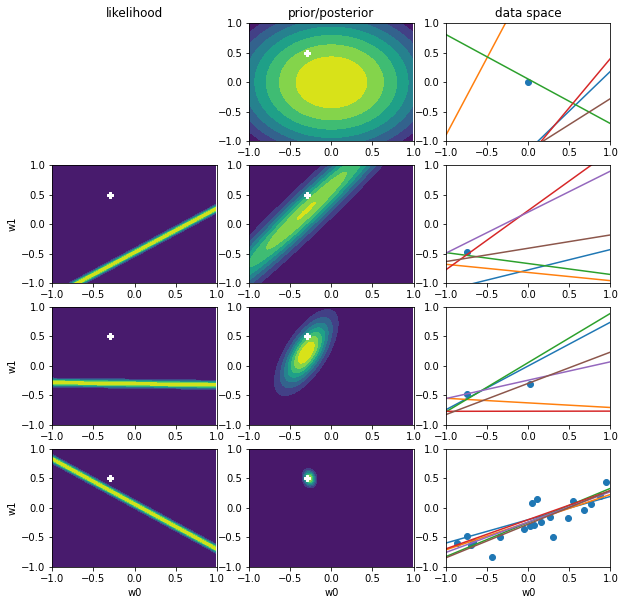

In [4]:
# -------------------------------------------- PLOTTING SETUP for Figure 3.7 ------------------------------------------

def axisSetup(ax, trueParameter):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    if (trueParameter>0):
      # true parameter values a0 = −0.3 and a1 = 0.5 used to generate the data set are shown by a white cross
      ax.scatter(a0, a1, marker='P', color = 'white')

      if (trueParameter == 1):
        ax.set_ylabel('w1')

    return ax


fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[10, 10])
ax[0, 0].set_title('likelihood')
ax[0, 1].set_title('prior/posterior')
ax[0, 2].set_title('data space')
ax[0, 0].axis('off')
for i in range(3): ax[3, i].set_xlabel('w0')

# -------------------------------------- SEQUENTIAL NATURE OF BAYESIAN LEARNING ------------------------------------------------

# FIRST ROW (before any data points are observed)
mean_0 = np.array([[0], [0]])
Std_0 = alpha * np.array([[1,0],[0,1]])
priorPosterior(mean_0, Std_0, ax[0, 1]) # plot of the prior distribution in w space
dataSpace(mean_0, Std_0, 0, 0, ax[0, 2]) 

# SECOND ROW (after observing a single data point) 
likelihood(x[0], tn[0], ax[1, 0]) 
mean_1, Std_1 = priorPosterior(mean_0, Std_0, ax[1, 1], x[0], tn[0]) 
dataSpace(mean_1, Std_1, x[0], tn[0], ax[1, 2])

# THIRD ROW (after observing a seccond data point) 
# This posterior has now been influenced by two data points, and because two points are sufficient to define a line this already gives a relatively compact posterior distribution.
likelihood(x[1], tn[1], ax[2, 0]) 
mean_2, Std_2 = priorPosterior(mean_1, Std_1,  ax[2, 1], x[1], tn[1]) 
dataSpace(mean_2, Std_2, x[:2], tn[:2], ax[2, 2]) 

# FOURTH ROW (after observing a total of 20 data points)
likelihood(x[19], tn[19], ax[3, 0])
mean_20, Std_20 = priorPosterior(mean_2, Std_2,  ax[3, 1], x[2:], tn[2:])
dataSpace(mean_20, Std_20, x, tn, ax[3, 2])

plt.show()

### Figure 3.8

In [32]:
mean = {}
S = {}
dataSetCount = [1, 2, 4, 25]
mean[0] = np.zeros([9, 1])
S[0] = 2 * np.identity(9)

def axisSetup(ax):
    ax.set_xlim(-.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    x = np.arange(0,1, .01) 
    y = np.sin(2 * np.pi *x)
    ax.plot(x,y, color='green')

def gaussbasis(phi, x):
  mu = np.linspace(0,1.5,9)
  sig = 0.3
  for k in range(phi.shape[1]):
    phi[:, k] = np.exp(-(x - mu[k])**2/(2*(sig)**2))

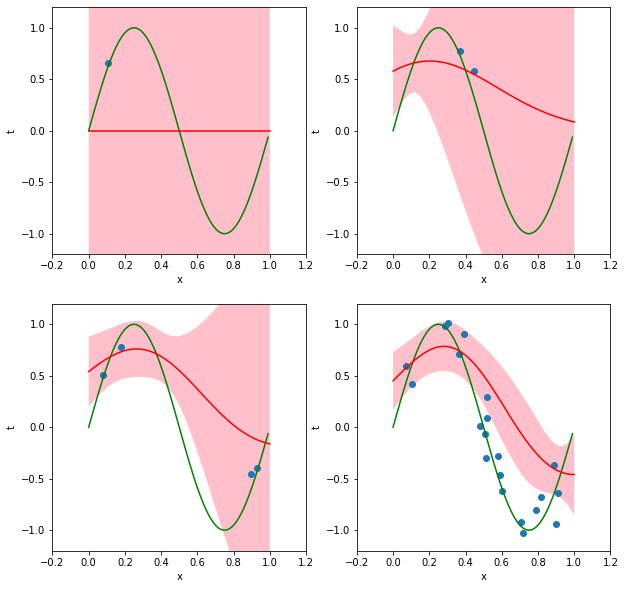

In [35]:
fig = plt.figure(figsize=[10,10])

for i in range(4):
  # plotting setup
  N = dataSetCount[i]
  axs = plt.subplot(2, 2, i+1)
  axisSetup(axs)

  # Obtain dataset with N values
  x = np.random.uniform(0, 1, N)
  t = np.sin(2 * np.pi *x) + np.random.normal(0, .2, N)

  # every row represents an additional datapoint
  if (isinstance(x, np.ndarray)):
        p = np.zeros((len(x), 9))
        t = np.reshape(t, (len(t), 1))   
  else:
        p = np.zeros((1, 9))
  
  # Gaussian basis functions used to updated mean and std 
  gaussbasis(p, x)
  S[i+1] = np.linalg.inv(np.linalg.inv(S[i]) + beta*np.dot(p.T, p))
  mean[i+1] = np.dot(S[i+1], np.dot(np.linalg.inv(S[i]), mean[i]) + beta*np.dot(p.T, t))

  # Calculate phi at each point for plotting, then correspoinding Mu and Std
  x_plot = np.linspace(0, 1)
  p = np.zeros((len(x_plot), 9))
  gaussbasis(p, x_plot)
  mn = np.matmul(p, mean[i]).T.squeeze()
  Sn = np.sqrt(1/beta + (np.matmul(p, S[i]) * p).sum(axis=1))
  axs.fill_between(x_plot, mn+Sn, mn-Sn, facecolor='pink')
  axs.plot(x_plot, mn, color='red')
  plt.scatter(x, t)

plt.show()